# Project Statement

A new community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [8]:
ls

README.md           imdb_reviews.tsv    ml_for_texts.ipynb


In [9]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [11]:
df_reviews.sample(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
27934,tt0138739,tvMiniSeries,Reckless,Reckless,1997,\N,310,0,"Drama,Romance",8.0,475,This group of English pros are a pleasure to w...,7,pos,1,train,4501
23092,tt0166924,movie,Mulholland Dr.,Mulholland Dr.,2001,\N,147,0,"Drama,Mystery,Thriller",8.0,309519,"It´s a joke, right?! Lynch could not get produ...",1,neg,0,test,2339
41895,tt0847897,movie,The Stone Angel,The Stone Angel,2007,\N,115,0,Drama,6.1,1641,I saw this movie last night after waiting ages...,9,pos,1,train,9982


Let's see whetrhere there are empty reviews, how those reviews lenght stack up

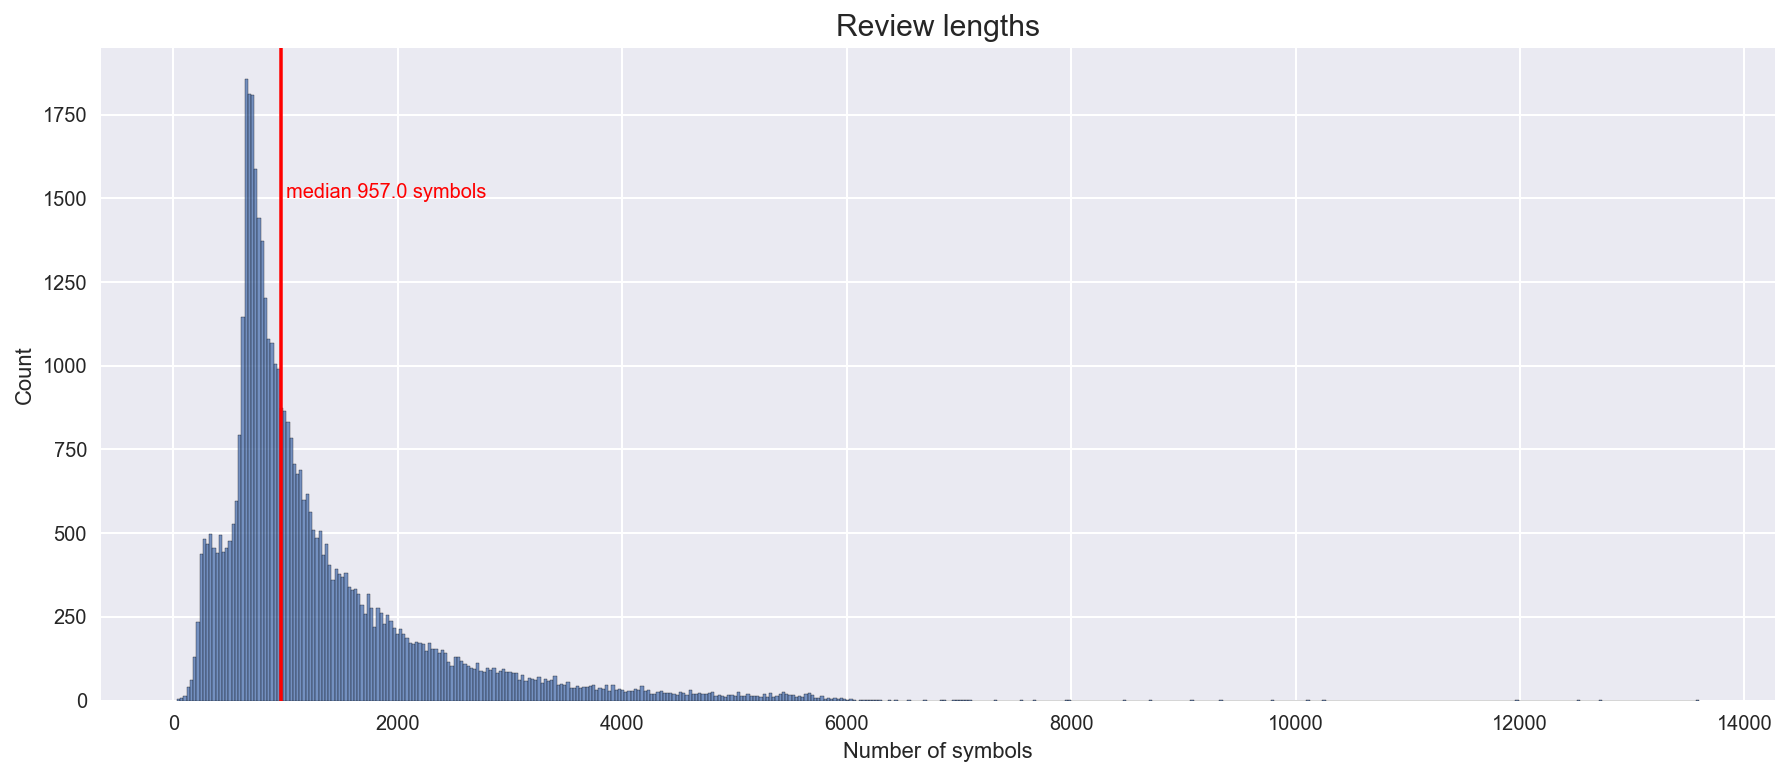

In [80]:
def review_len(row):
    return len(row['review'])

review_length = df_reviews.apply(review_len, axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

plt.axvline(x=review_length.median(),color='red', label='median')
plt.text(1000, 1500, f'median {review_length.median()} symbols', rotation=0, color='red')

sns.histplot(review_length, bins=int(df_reviews.shape[0]/100), ax=ax)
ax.set_title('Review lengths', fontsize=15)
ax.set_xlabel('Number of symbols');

In [83]:
print(f'99% of reviews are {int(np.percentile(review_length, 99))} symbols or shorter')
review_length.describe()

99% of reviews are 5108 symbols or shorter


count    47331.000000
mean      1290.030973
std        974.976807
min         32.000000
25%        691.000000
50%        957.000000
75%       1566.000000
max      13594.000000
dtype: float64

Good news, no empty reviews.<br> Majority of reviews are under 5000 signs. 

In [9]:
df_reviews.duplicated().sum()

0

No duplicated values <br>
Let's check for missing values

In [10]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [11]:
df_reviews[(df_reviews['average_rating'].isna()) | (df_reviews['votes'].isna())]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [12]:
df_reviews.query("tconst == 'tt0192317'")

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


We are missing average rating and number of votes for a movie 'Mila Ass Painting'. We could've restored it manually, but it's missing rating on imdb itself as well. Alternatively, having two reviews with rating 9 and 10 we could assign manually average rating to 9.5 and votes to 2. Yet it's not nessary as we will not use this field in model training

In [13]:
df_reviews.loc[df_reviews['average_rating'].isna(), 'average_rating'] = 9.5
df_reviews.loc[df_reviews['votes'].isna(), 'votes'] = 2

## EDA

Let's check the number of movies and reviews over years.

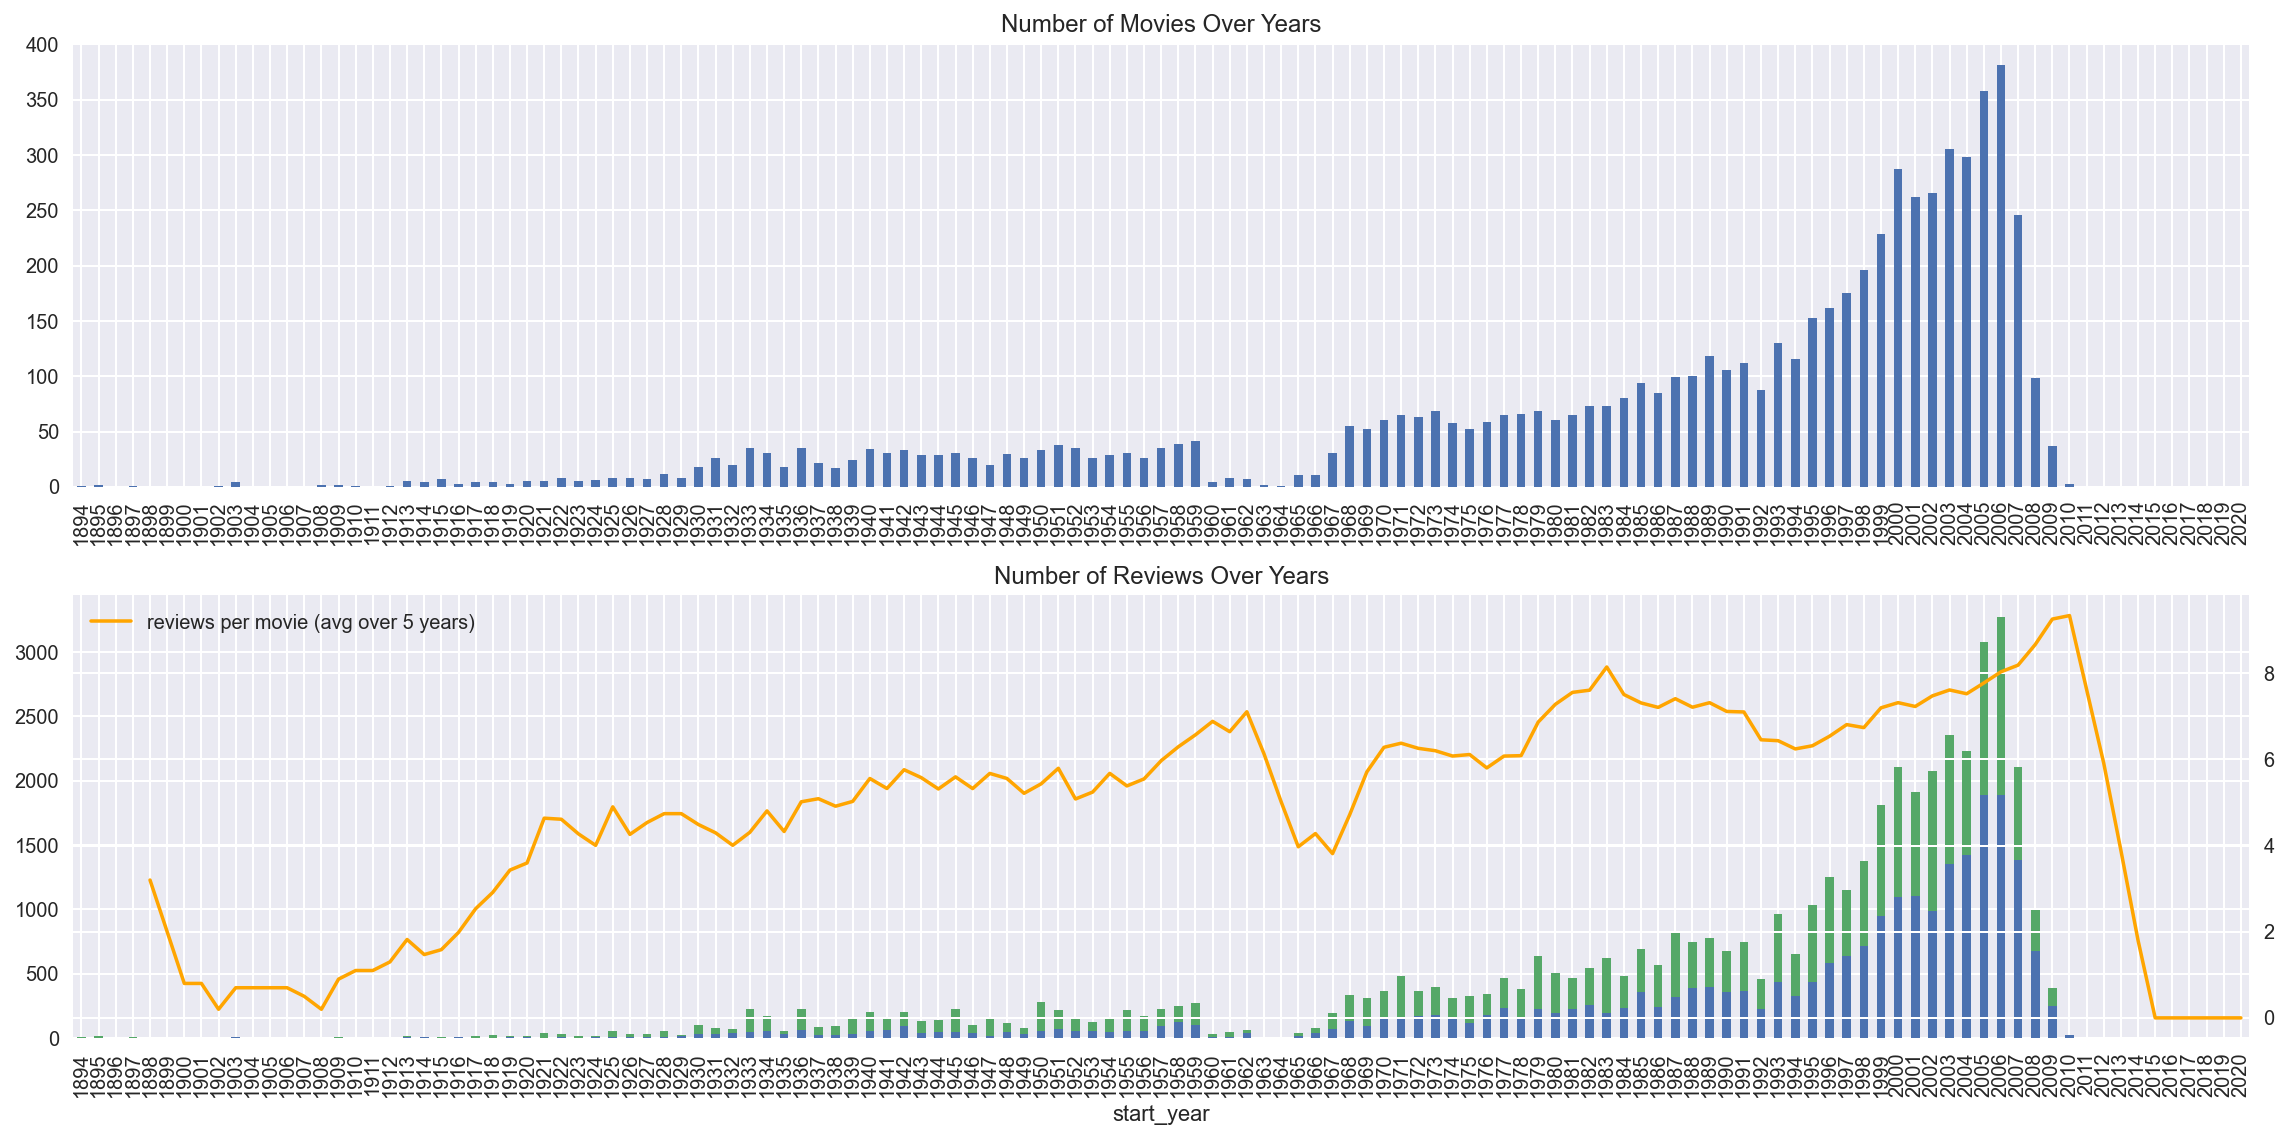

In [84]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

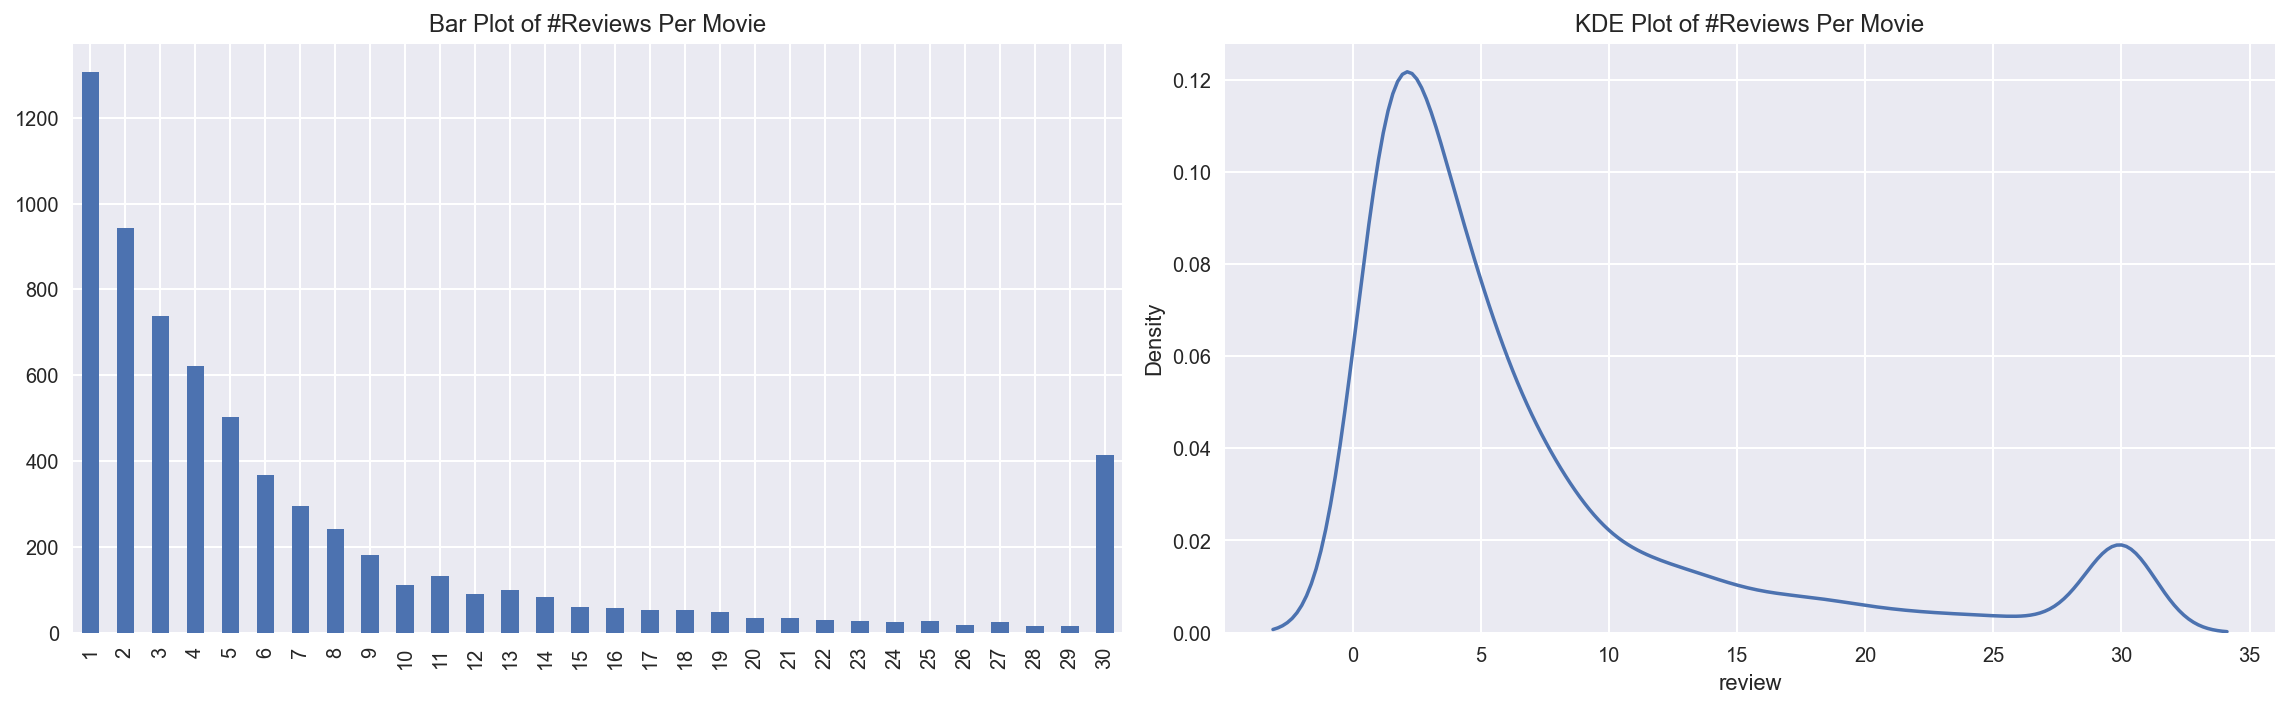

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [86]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Number of positive and negative reviews nearly equal, making our target well balanced

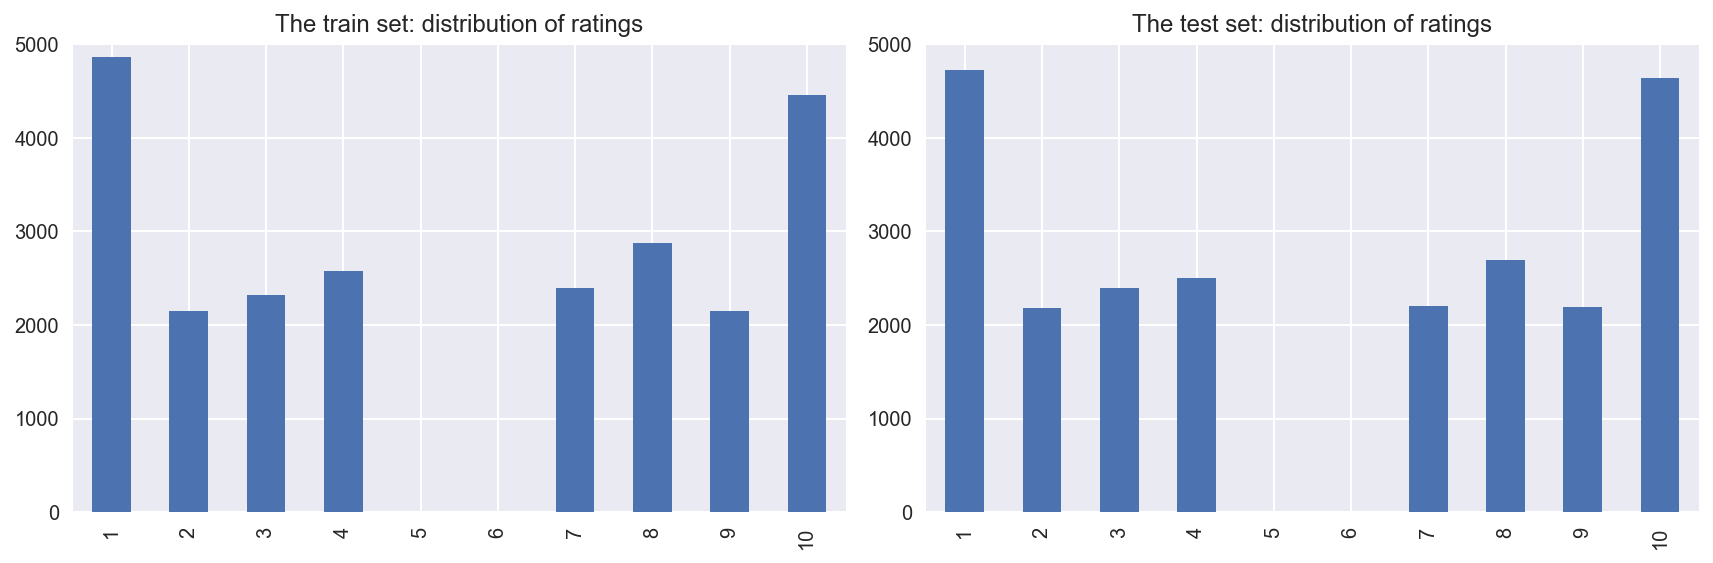

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Seems like reviwers don't like giving an average score, as it lacks opinion. Or such 'average' movies are not worth time spent on writing a review in their mind. <br>
Also distribution of ratings is very similar among train and test data sets

Distribution of negative and positive reviews over the years for two parts of the dataset

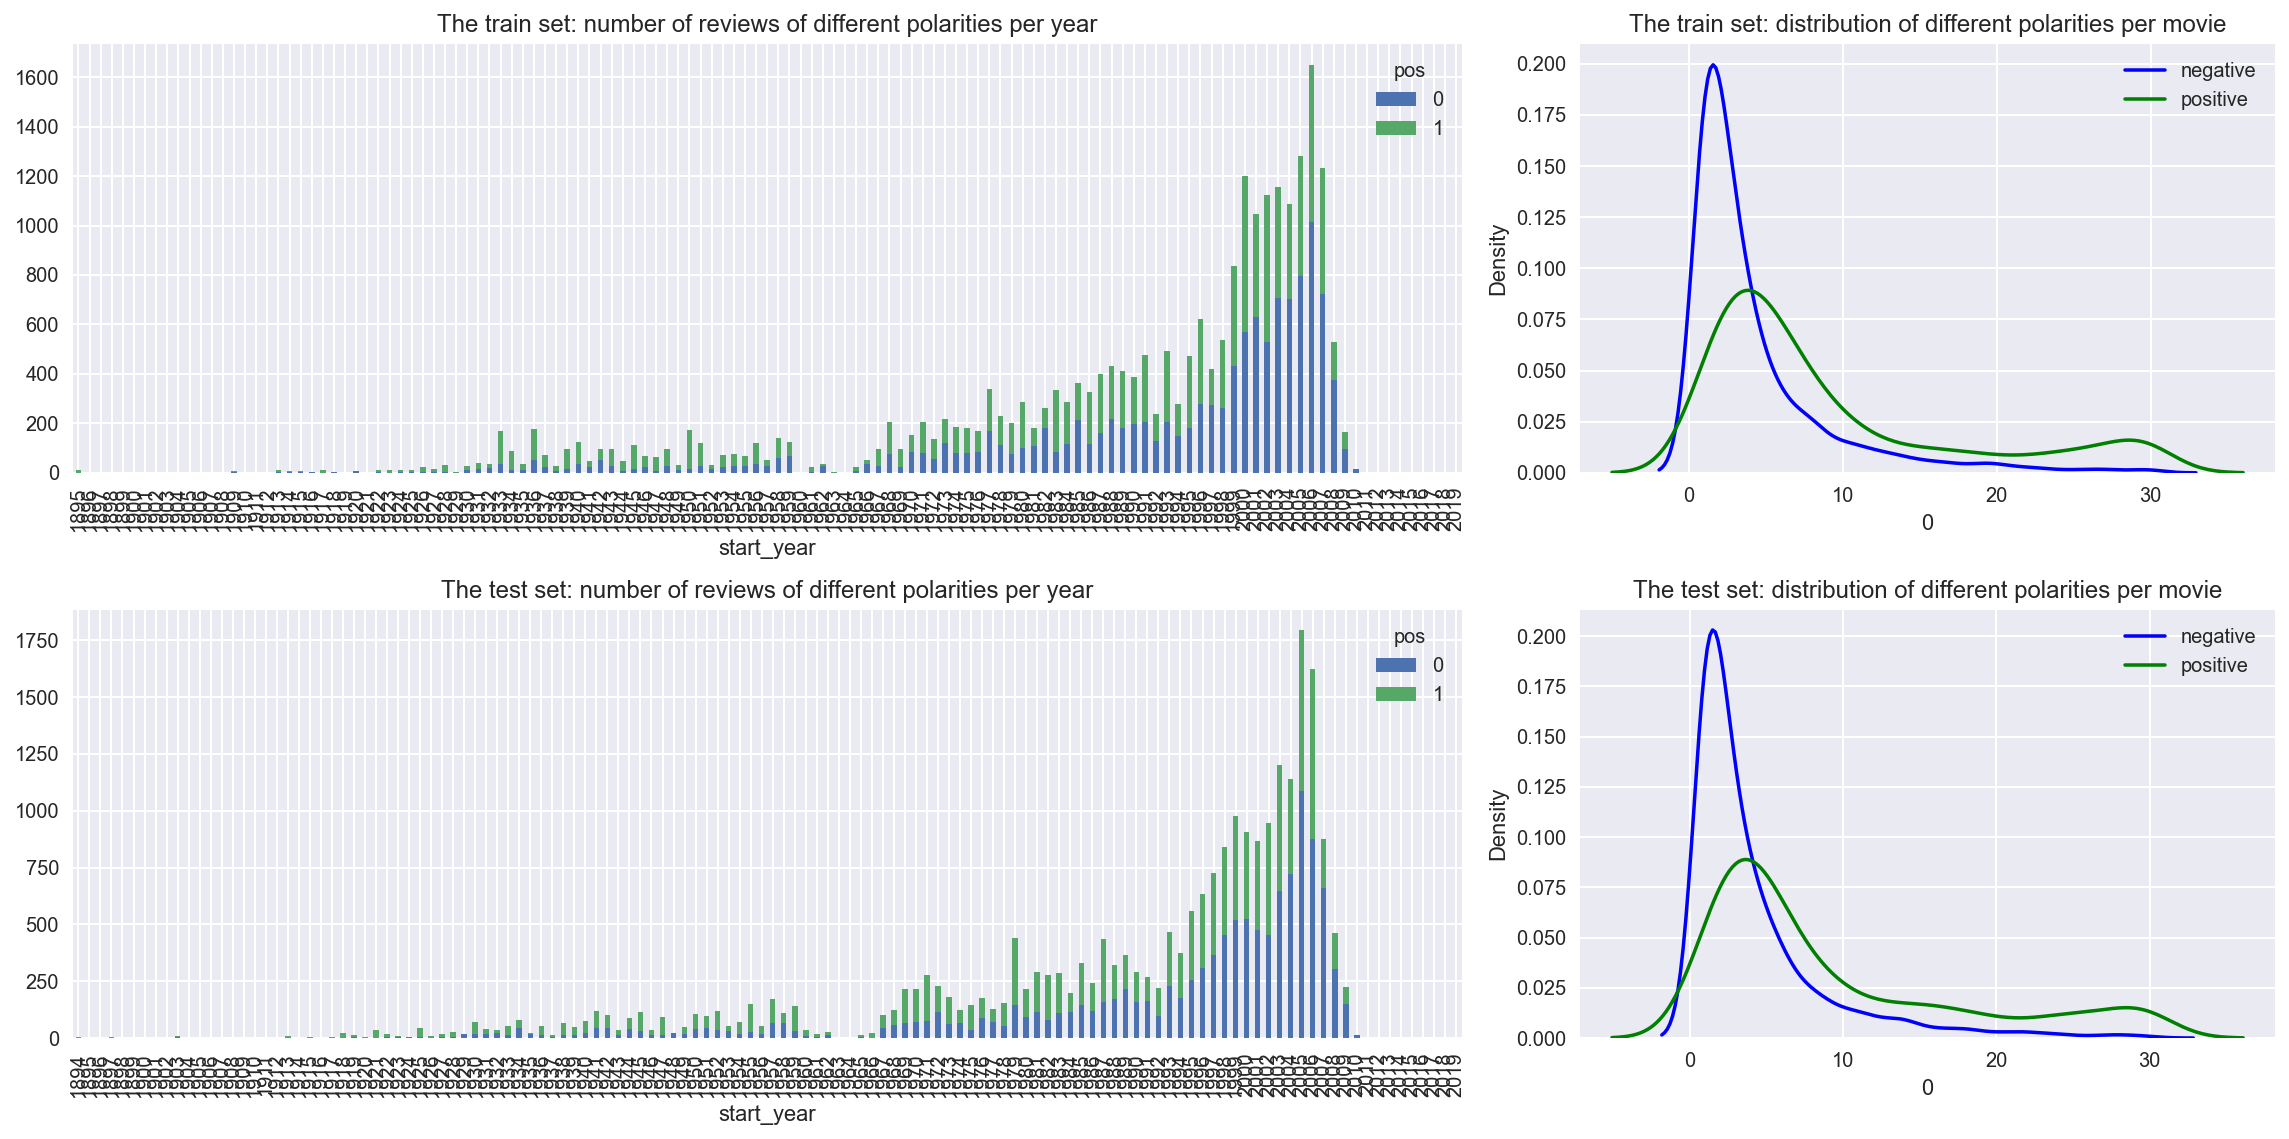

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Data was split evenly into train and test sets. Distributions are very similar. We can proceed to model training 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [19]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [20]:
import re

def normalize(text):
    # in case we dont want to preserve apostrophe in the middle of the word (wasn't) use "[a-z]"
    return ' '.join(re.findall("[a-z]+\'?[a-z]", text.lower()))

In [21]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

In [22]:
# this one is relatively short
r_index = random.choice(df_reviews.index)
print(f"Original review: {df_reviews['review'].iloc[r_index]}")
print()
print(f"Normalized review: {df_reviews['review_norm'].iloc[r_index]}")

Original review: My website (www.theflickguy.org) lists this pick as the worst movie of all time. Here is an excerpt: "If I were strapped down to a chair and forced to watch this movie over and over again, I couldn't imagine Hell being any worse. Jim Varney plays a three-handed crazy guy bent on destroying the world (apparently starting with cinema). Now let's face it, no one expects a whole lot from a Varney movie, but this agonizing drivel had me dry-heaving for 92 minutes. Not a laugh. Not one. This is not kamp or gitchy, this is not even mindless. It is evil. Do not rent this, it may destroy your DVD player. Do not even buy the VHS from a 29-cent clearance bin to use as a blank tape. It is the worst film of all time. Period. I mean it. Really."

Normalized review: my website www theflickguy org lists this pick as the worst movie of all time here is an excerpt if were strapped down to chair and forced to watch this movie over and over again couldn't imagine hell being any worse jim 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Text data was normalized successfully

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

In [24]:
results = {}

### Model 0 - Constant

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
dummy = DummyClassifier()

In [27]:
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']
y_train = train_target
y_test = test_target

In [28]:
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

Changed in version 0.24: The default value of strategy has changed to “prior” in version 0.24.

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


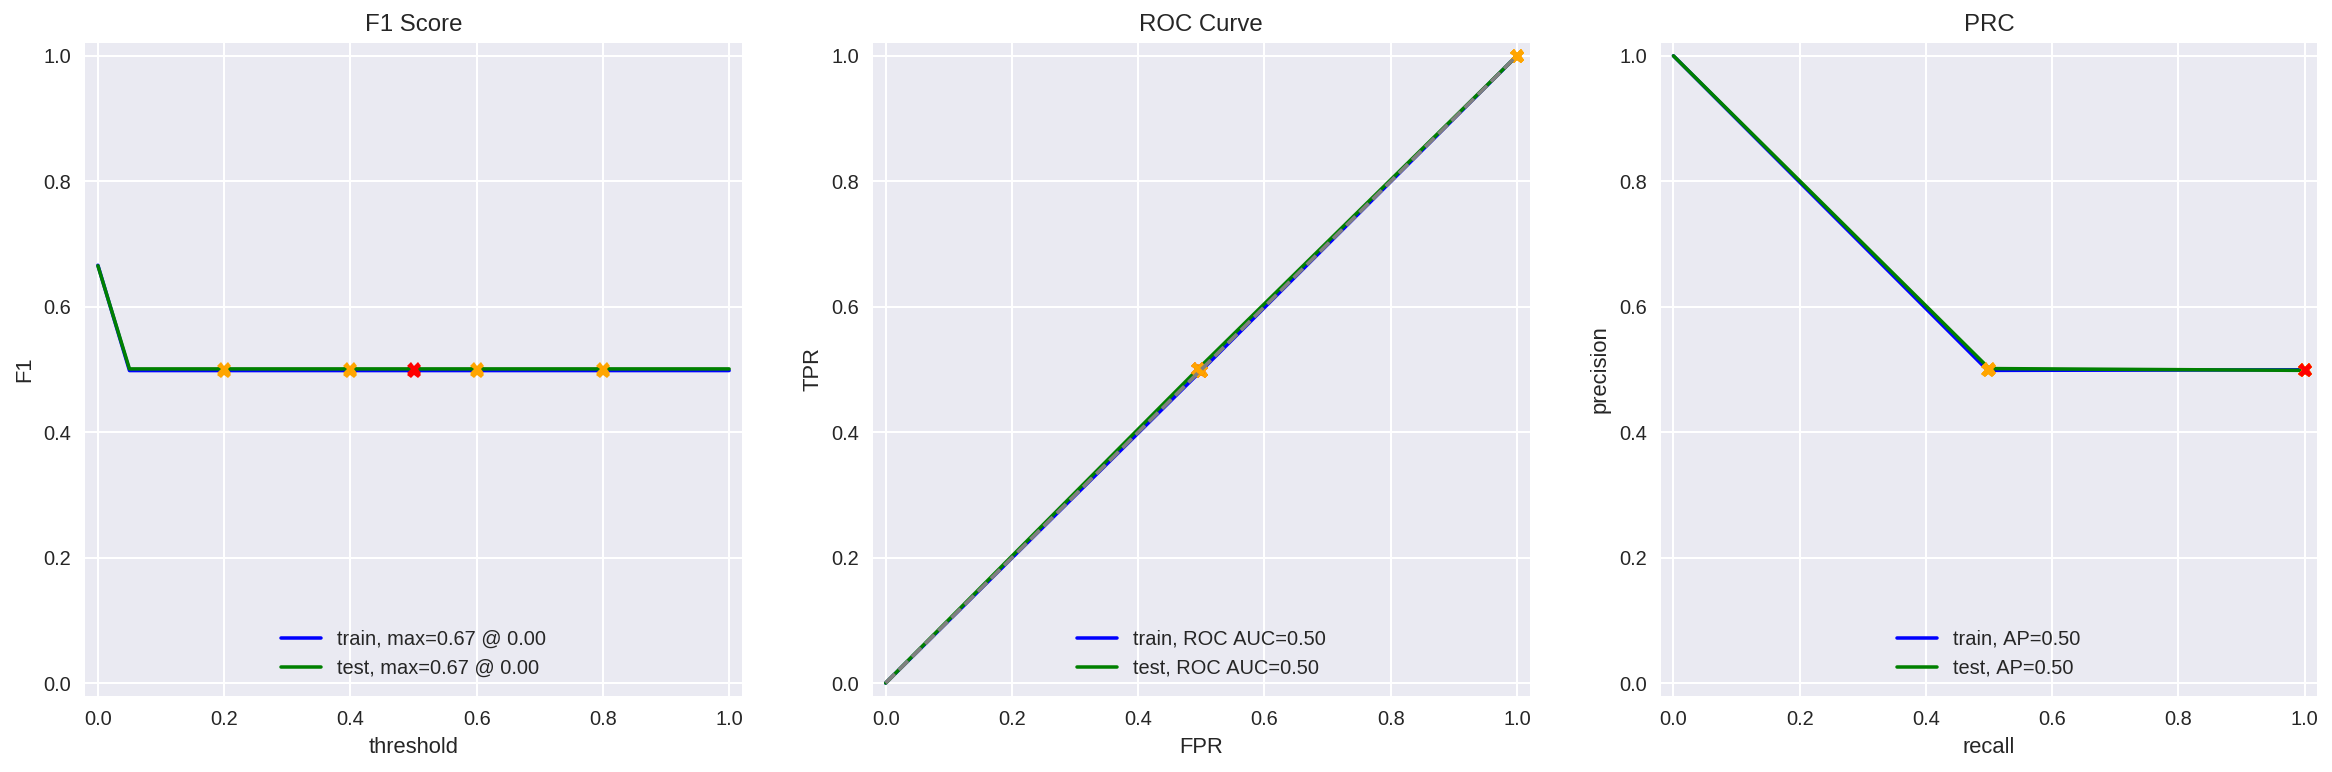

In [29]:
results['dummy_model'] = evaluate_model(dummy, X_train, y_train, X_test, y_test)

Here's our dummy at it's best. Average as it gets

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [30]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [31]:
stop_words = set(stopwords.words('english'))

train_corpus_1 = df_reviews_train['review_norm']
test_corpus_1 = df_reviews_test['review_norm']

tf_idf_vect_1 = TfidfVectorizer(stop_words=stop_words) 
tf_idf_vect_1.fit(train_corpus_1)
train_features_1 = tf_idf_vect_1.transform(train_corpus_1)
test_features_1 = tf_idf_vect_1.transform(test_corpus_1)

In [32]:
model_1 = LogisticRegression(solver = 'liblinear')
model_1.fit(train_features_1, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


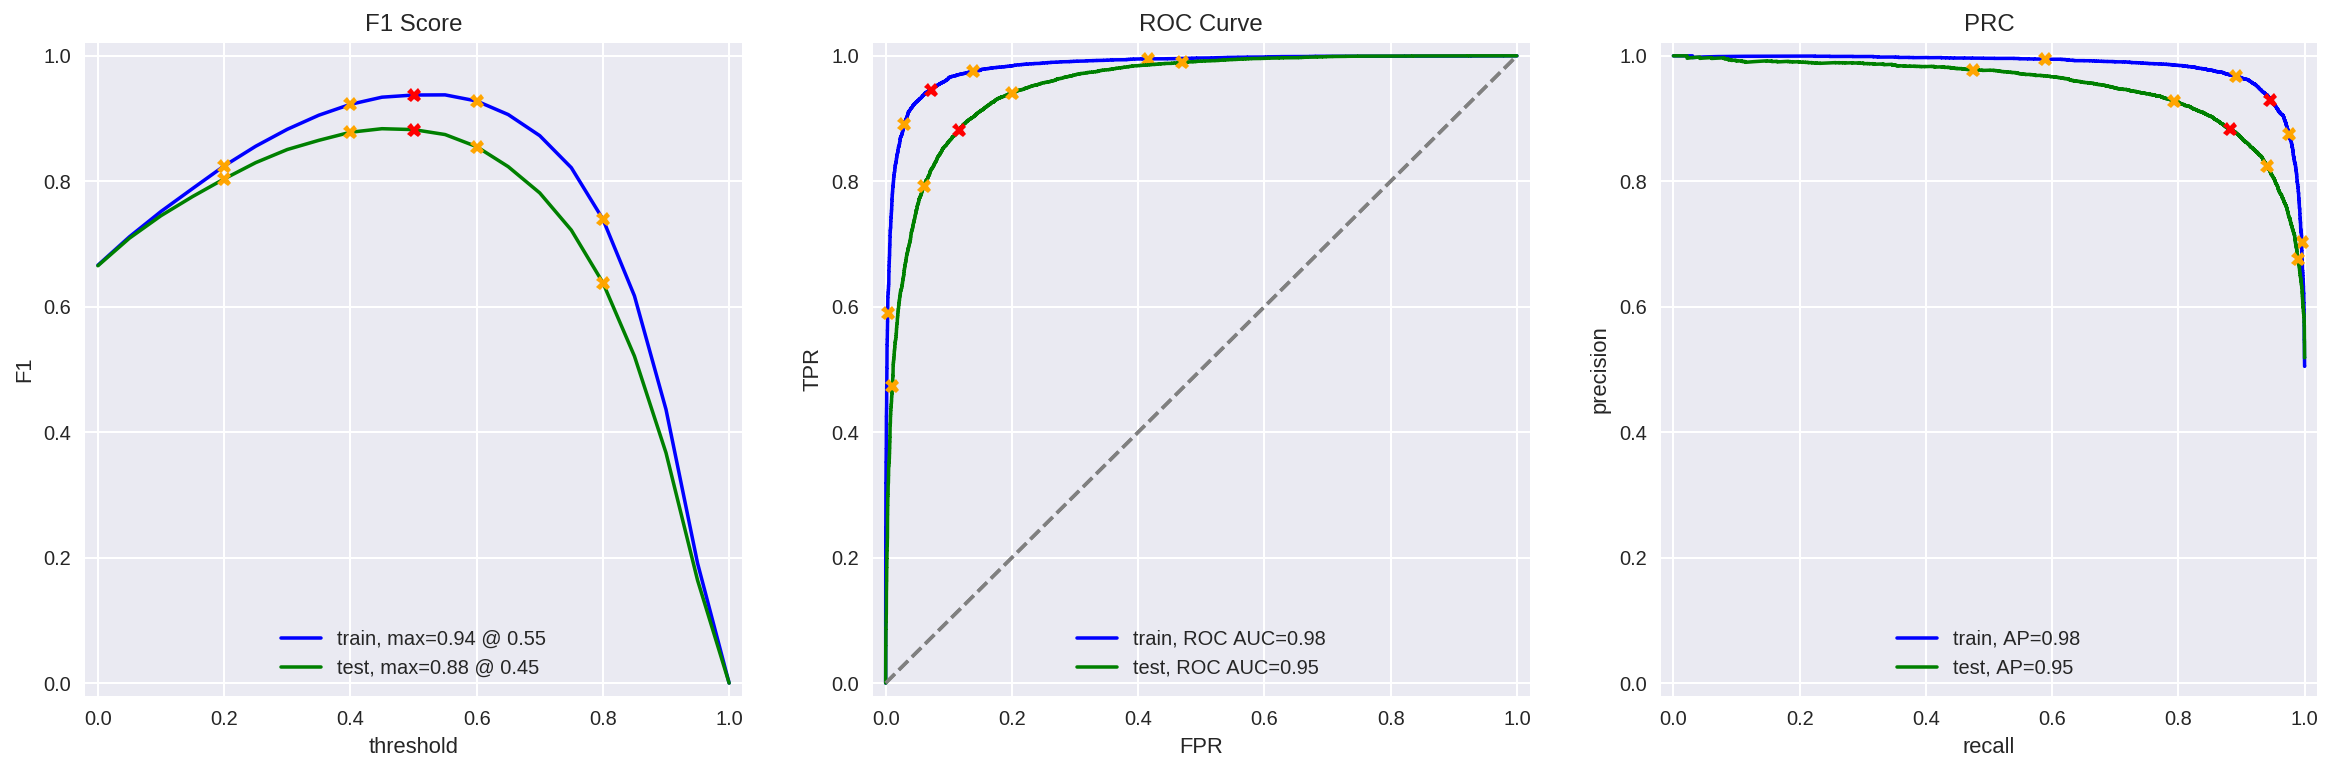

In [33]:
results['nltk_tfidf_lr'] = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [35]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [37]:
%%time
train_corpus_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
test_corpus_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

CPU times: user 8min 55s, sys: 750 ms, total: 8min 56s
Wall time: 9min 4s


In [38]:
r_index = random.choice(train_corpus_1.index)
print(f"Original review: {df_reviews['review'].loc[r_index]}")
print()
print(f"Normalized review: {train_corpus_1.loc[r_index]}")
print()
print(f"Lemmatized review: {train_corpus_3.loc[r_index]}")

Original review: I'm not usually a fan of strictly romantic movies but heard this was good. I was stunned. Easily the most romantic thing I've ever seen in my life. Stunning. Brilliant, sweet, funny and full of heart. The chemistry is flawless as is the writing and directing. Ethan Hawke and Julie Delphy are so natural and sweet together you really think they're a couple. The movies grabs you right away and doesn't let go. You can't look away nor can you stop listening to them. Even the little moments just melt your heart. This has jumped into the ranks of one of my favourite ever. A masterpiece.

Normalized review: i'm not usually fan of strictly romantic movies but heard this was good was stunned easily the most romantic thing i'v ever seen in my life stunning brilliant sweet funny and full of heart the chemistry is flawless as is the writing and directing ethan hawke and julie delphy are so natural and sweet together you really think they'r couple the movies grabs you right away and

In [39]:
# def remove_pron(text):
#     return ' '.join(re.sub("-PRON-", ' ', text).split())

# train_corpus_2 = train_corpus_2.apply(remove_pron)
# test_corpus_2 = test_corpus_2.apply(remove_pron)

In [40]:
tf_idf_vect_3 = TfidfVectorizer(stop_words=stop_words) 
tf_idf_vect_3.fit(train_corpus_3)
train_features_3 = tf_idf_vect_3.transform(train_corpus_3)
test_features_3 = tf_idf_vect_3.transform(test_corpus_3)

In [41]:
model_3 = LogisticRegression(solver = 'liblinear')
model_3.fit(train_features_3, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


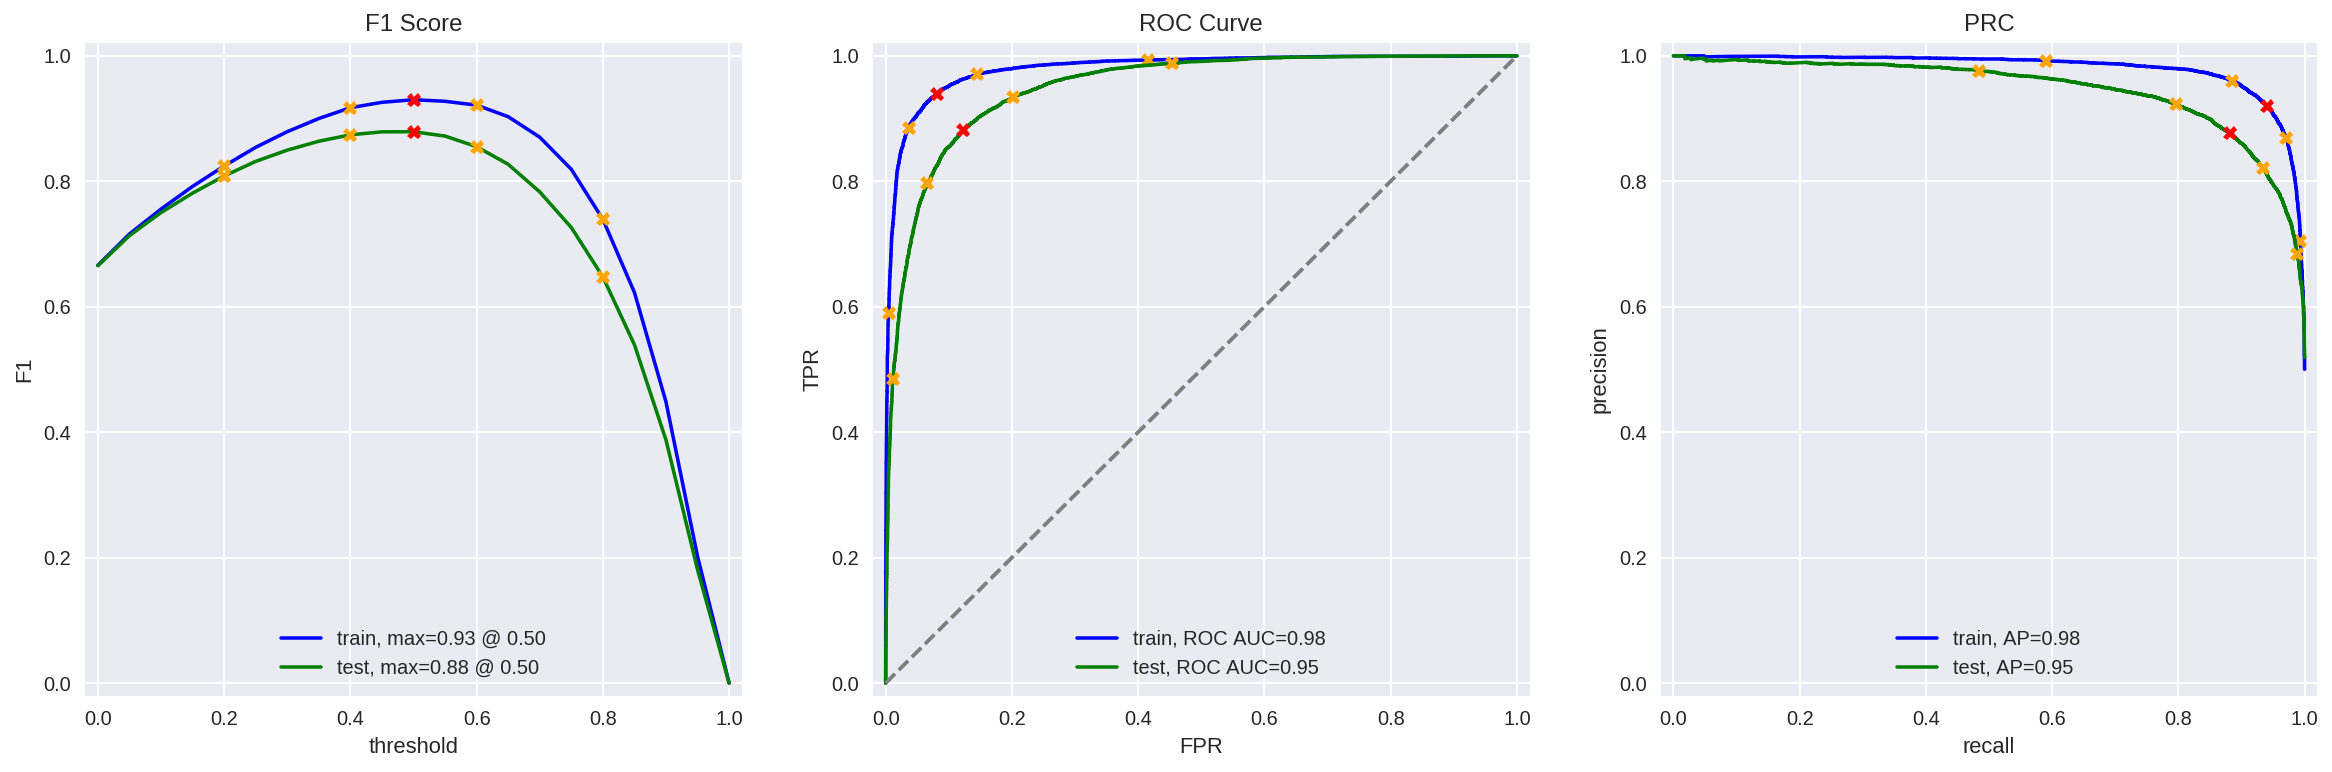

In [42]:
results['spaCy_tfidf_lr'] = evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [43]:
from lightgbm import LGBMClassifier

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
%%time
train_corpus_sample = df_reviews_train['review_norm'].sample(1000, random_state=1).apply(text_preprocessing_3)
test_corpus_sample = df_reviews_test['review_norm'].sample(1000, random_state=1).apply(text_preprocessing_3)

tf_idf_vect = TfidfVectorizer(stop_words=stop_words) 
tf_idf_vect.fit(train_corpus_sample)
train_features_sample = tf_idf_vect.transform(train_corpus_sample)
test_features_sample = tf_idf_vect.transform(test_corpus_sample)

train_target_sample = train_target.sample(1000, random_state=1)
test_target_sample = test_target.sample(1000, random_state=1)

CPU times: user 21.4 s, sys: 27.1 ms, total: 21.4 s
Wall time: 21.7 s


In [46]:
%%time
model = GridSearchCV(LGBMClassifier(), cv=3, param_grid = {'learning_rate':np.arange(0.05, 0.15, 0.01)}, scoring='f1')
model.fit(train_features_sample, train_target_sample)

CPU times: user 2min 10s, sys: 1.18 s, total: 2min 11s
Wall time: 2min 13s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,

In [47]:
model_4 = LGBMClassifier(learning_rate = model.best_params_['learning_rate'])
model_4.fit(train_features_3, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


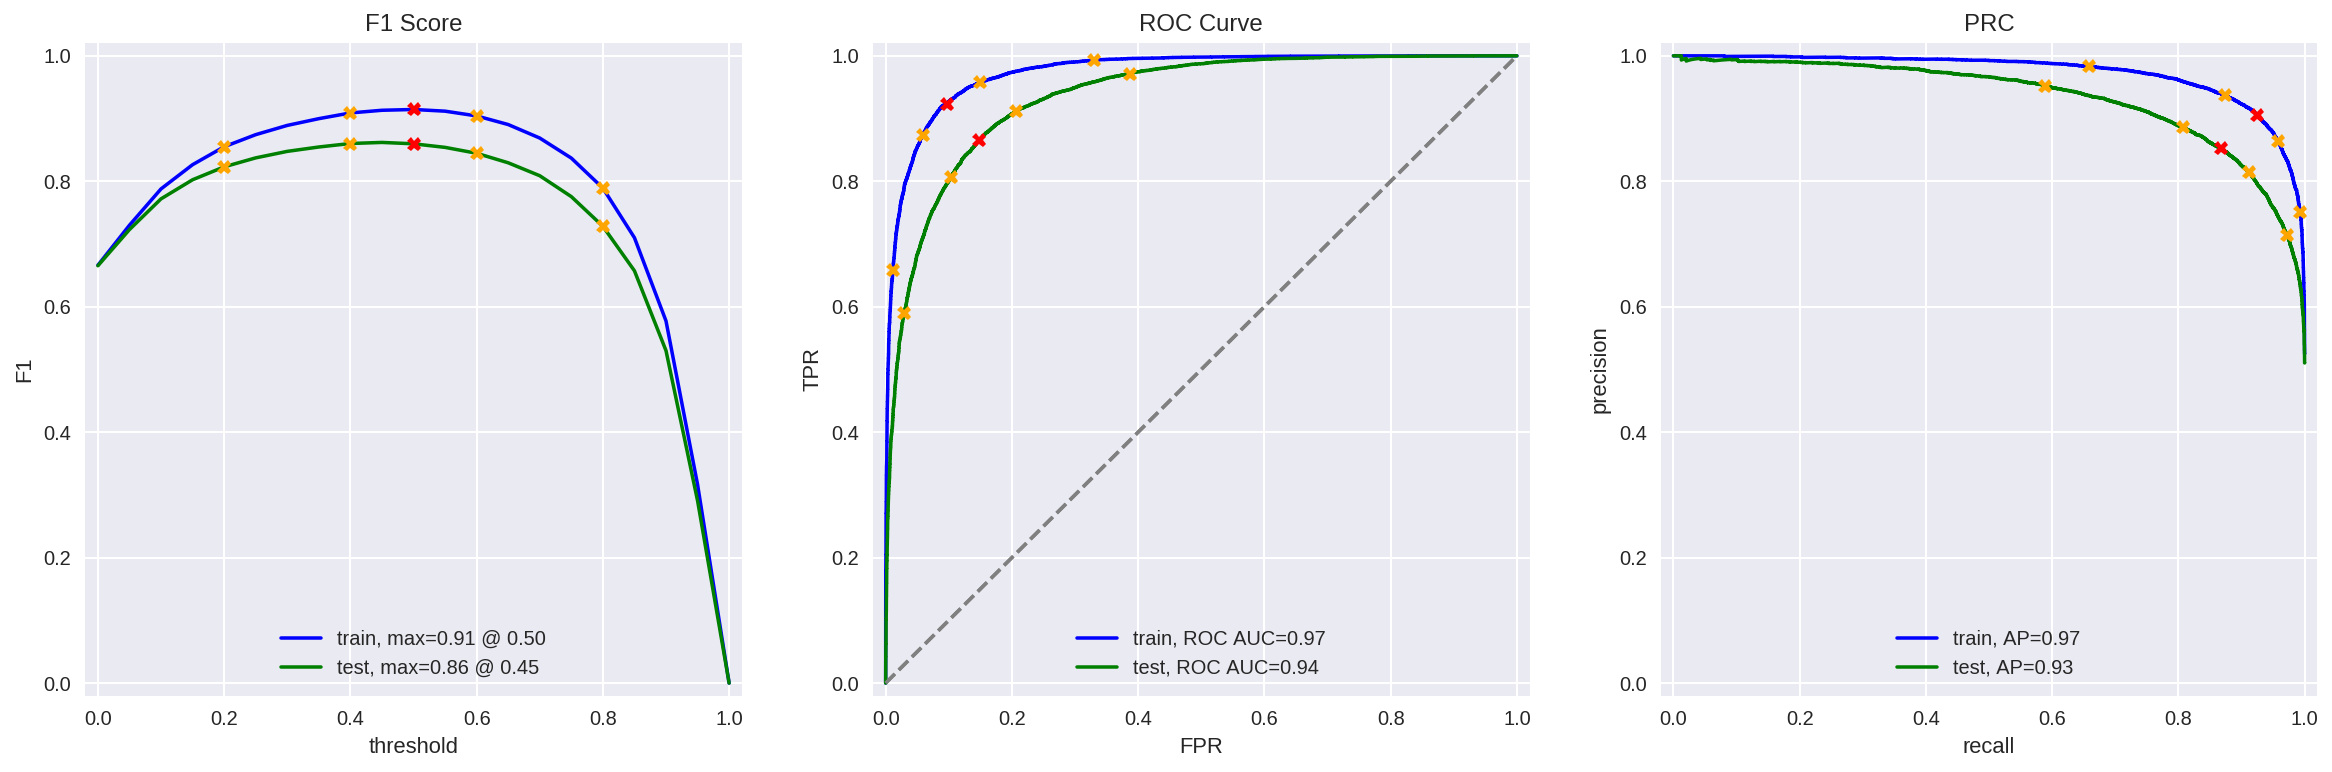

In [48]:
results['spaCy_tfidf_LGBMC'] = evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [49]:
import torch
import transformers

In [50]:
torch.__version__

'1.5.1'

In [121]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [122]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [124]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'].sample(100, random_state=1), batch_size=10)
# test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'].sample(100, random_state=1), batch_size=10)

Well, that took a lot of time just for 100 elements. <br>
I used google colab and saved resulting features to hub repositry

In [54]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [55]:
print(train_features_9.shape)
print(train_target.shape)
print(test_features_9.shape)
print(test_target.shape)

(23796, 768)
(23796,)
(23535, 768)
(23535,)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


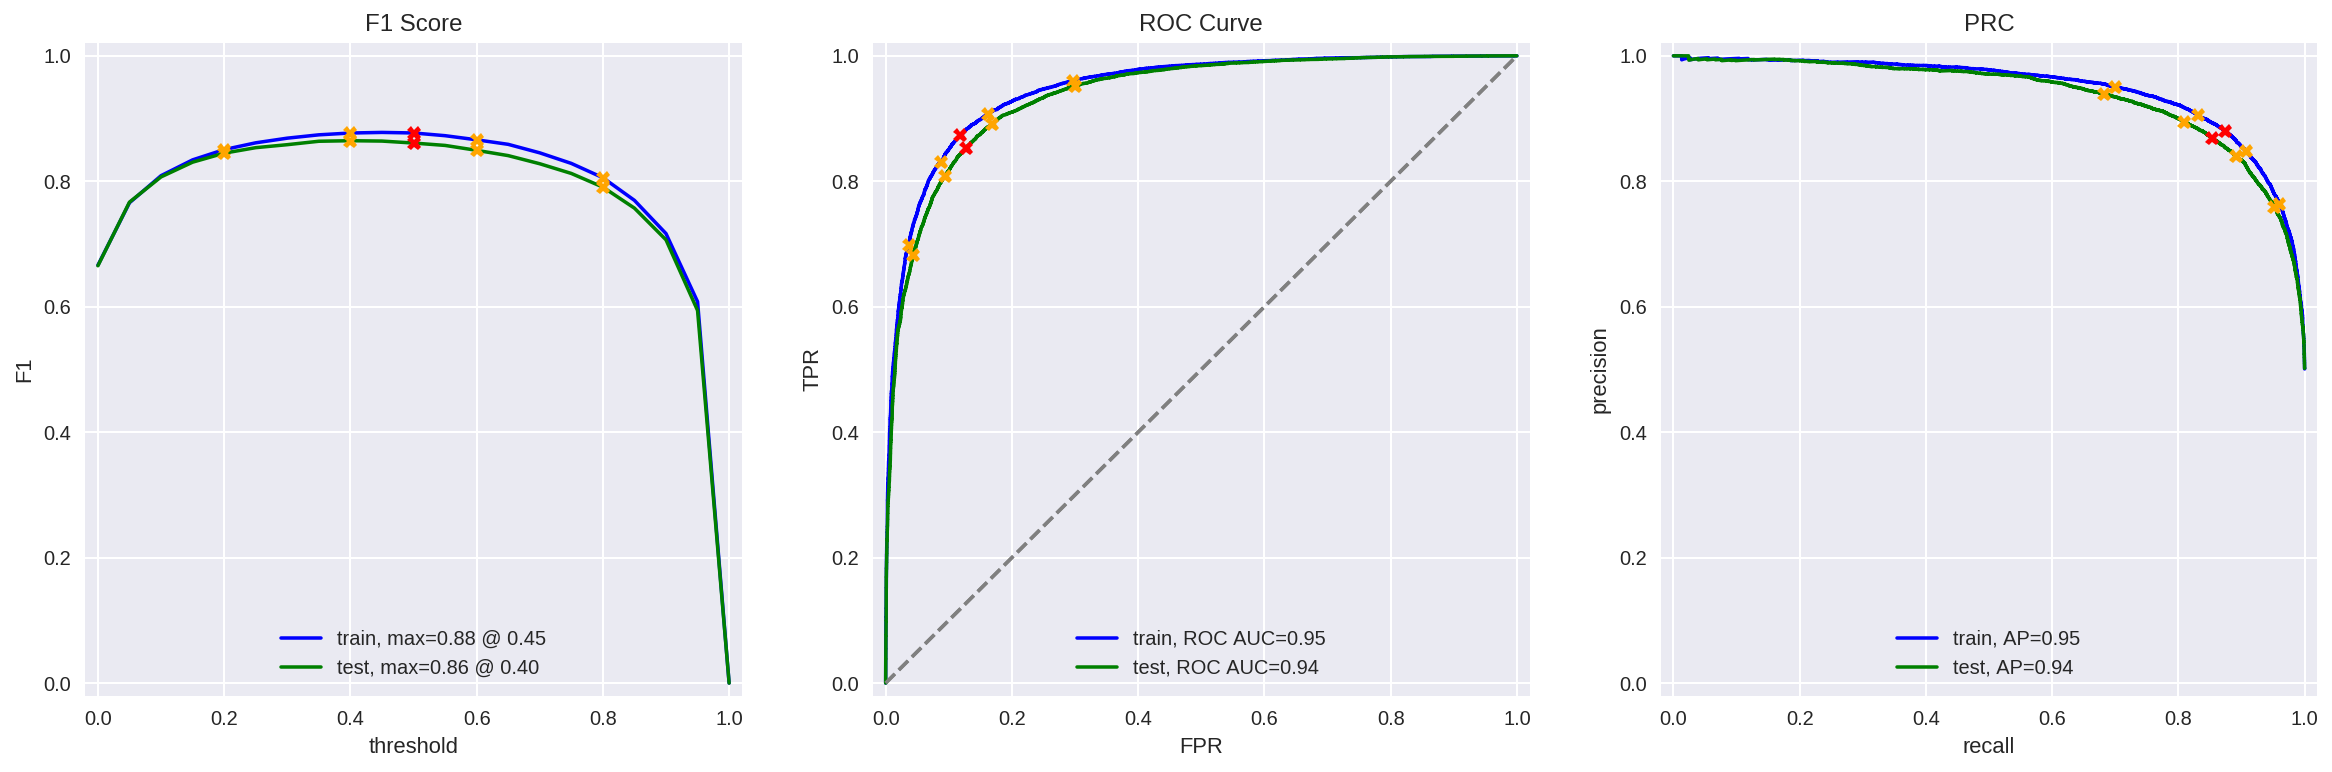

In [56]:
model_9 = LogisticRegression(solver='liblinear')
model_9.fit(train_features_9, train_target)

results['bert_lr'] = evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

In [110]:
# train_index = np.random.choice(len(train_features_9), 1000)
# test_index = np.random.choice(len(test_features_9), 1000)
# train_sample_features = train_features_9[train_index]
# train_sample_target = train_target.iloc[train_index]
# test_sample_features = test_features_9[test_index]
# test_sample_target = test_target.iloc[test_index]

# %%time
# model_99 = GridSearchCV(LGBMClassifier(), cv=3, param_grid = {'learning_rate':np.arange(0.05, 0.15, 0.01), 'reg_lambda':np.arange(0.0, 0.5, 0.1)}, scoring='f1')
# model_99.fit(train_sample_features, train_sample_target)
# evaluate_model(model_99, train_sample_features, train_sample_target, test_sample_features, test_sample_target)

In [108]:
model_99.best_params_

{'learning_rate': 0.08000000000000002, 'reg_lambda': 0.30000000000000004}

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.92  0.84
F1         0.92  0.83
APS        0.98  0.92
ROC AUC    0.98  0.92


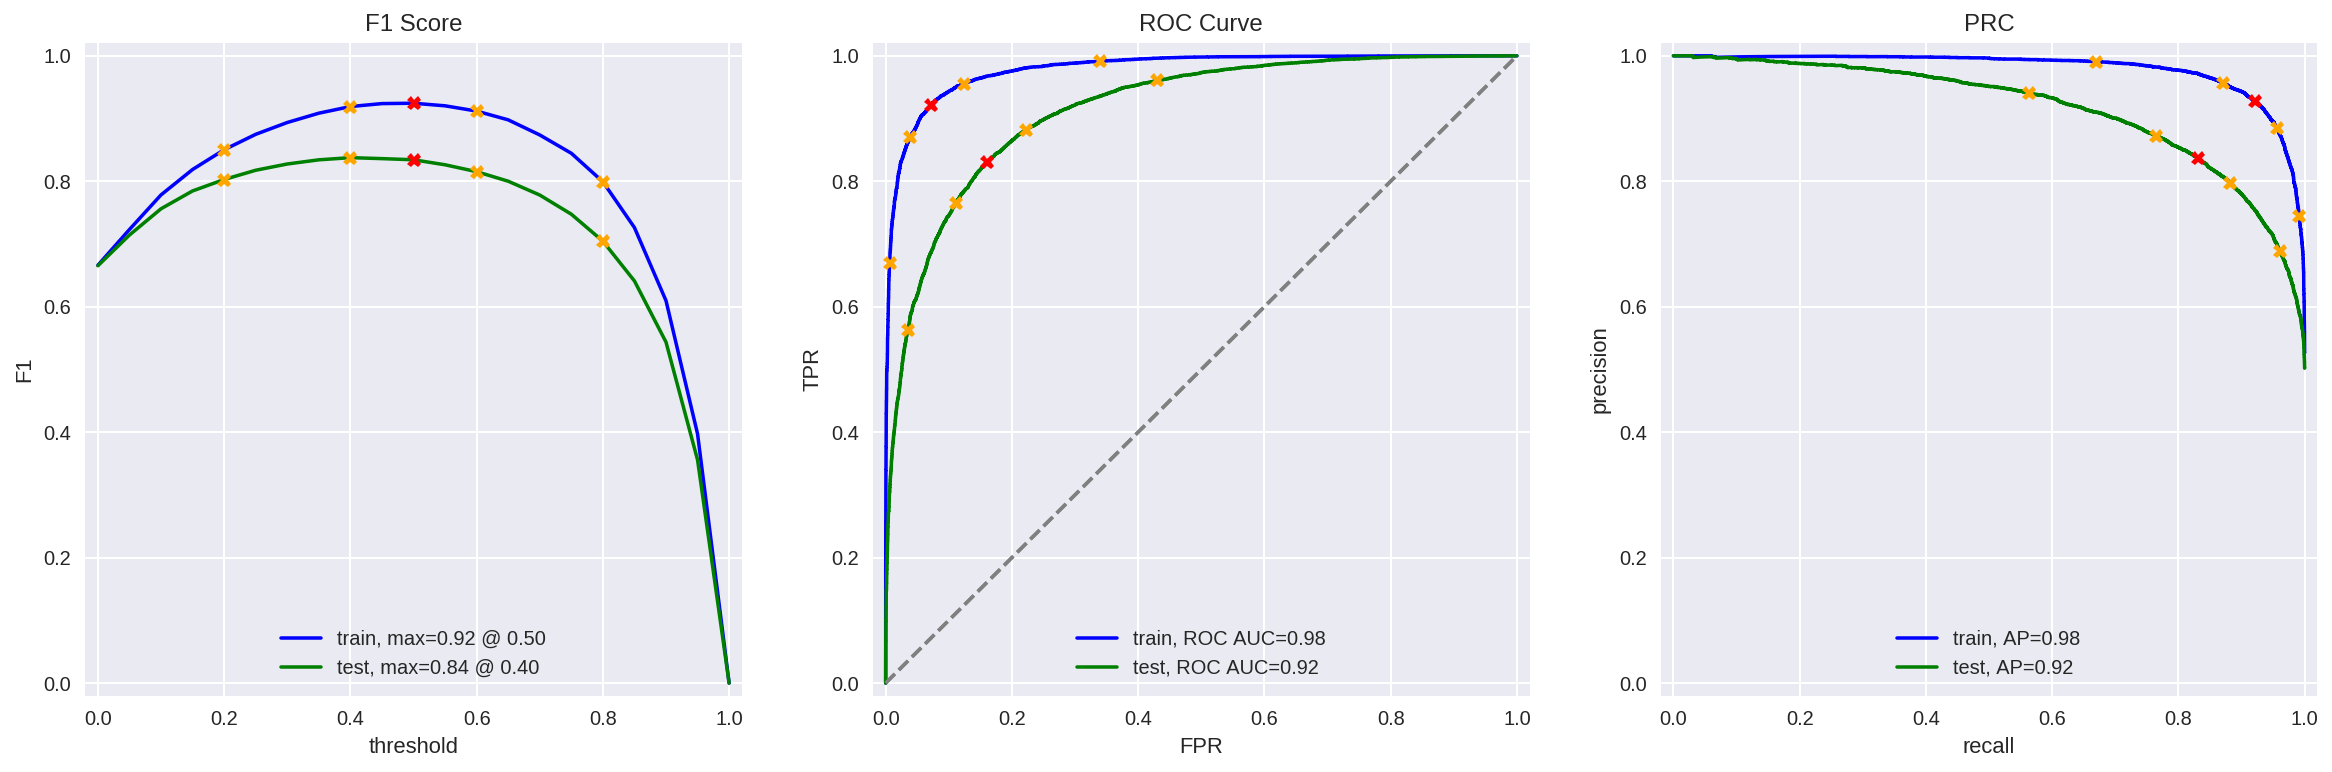

In [111]:
model_10 = LGBMClassifier()
model_10.fit(train_features_9, train_target)
results['bert_LGBMC'] = evaluate_model(model_10, train_features_9, train_target, test_features_9, test_target)

## My Reviews

In [126]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'Worst instalation in whole franchize. Waste of time and money. Would not recomend it to my worst enemy',
    'Highly anticipated sequel, and it delivered. Best three hours of this year.',
    'Was not expecting anythig from this adaptation. And was pretty surprised what creators managed to deliver'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)
# my_reviews['review_lemm'] = my_reviews['review'].apply(text_preprocessing_3)
# my_reviews['review_lemm'] = my_reviews['review_lemm'].apply(remove_pron)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well was bored and felt asleep in the middle o...
2,I was really fascinated with the movie,was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,didn't expect the reboot to be so good writers...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but fe...
6,What a rotten attempt at a comedy. Not a singl...,what rotten attempt at comedy not single joke ...
7,Launching on Netflix was a brave move & I real...,launching on netflix was brave move really app...
8,Worst instalation in whole franchize. Waste of...,worst instalation in whole franchize waste of ...
9,"Highly anticipated sequel, and it delivered. B...",highly anticipated sequel and it delivered bes...


### Model 1

In [127]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tf_idf_vect_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  did not simply like it not my kind of movie
0.16:  well was bored and felt asleep in the middle of the movie
0.54:  was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what soulle
0.31:  didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but feel like overall it's decent flick could see myself goi
0.04:  what rotten attempt at comedy not single joke lands everyone acts annoying and loud even kids won't 
0.82:  launching on netflix was brave move really appreciate being able to binge on episode after episode o
0.00:  worst instalation in whole franchize waste of time and money would not recomend it to my worst enemy
0.75:  highly anticipated sequel and it delivered best three hours of this year
0.69:  was not expecting anythig from this adaptation and was pretty surprised what creators managed to del


### Model 3

In [128]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tf_idf_vect_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  did not simply like it not my kind of movie
0.09:  well was bored and felt asleep in the middle of the movie
0.45:  was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what soulle
0.24:  didn't expect the reboot to be so good writers really cared about the source material
0.56:  the movie had its upsides and downsides but feel like overall it's decent flick could see myself goi
0.02:  what rotten attempt at comedy not single joke lands everyone acts annoying and loud even kids won't 
0.92:  launching on netflix was brave move really appreciate being able to binge on episode after episode o
0.00:  worst instalation in whole franchize waste of time and money would not recomend it to my worst enemy
0.67:  highly anticipated sequel and it delivered best three hours of this year
0.71:  was not expecting anythig from this adaptation and was pretty surprised what creators managed to del


### Model 4

In [129]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tf_idf_vect_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.66:  did not simply like it not my kind of movie
0.28:  well was bored and felt asleep in the middle of the movie
0.60:  was really fascinated with the movie
0.34:  even the actors looked really old and disinterested and they got paid to be in the movie what soulle
0.70:  didn't expect the reboot to be so good writers really cared about the source material
0.70:  the movie had its upsides and downsides but feel like overall it's decent flick could see myself goi
0.23:  what rotten attempt at comedy not single joke lands everyone acts annoying and loud even kids won't 
0.79:  launching on netflix was brave move really appreciate being able to binge on episode after episode o
0.04:  worst instalation in whole franchize waste of time and money would not recomend it to my worst enemy
0.88:  highly anticipated sequel and it delivered best three hours of this year
0.61:  was not expecting anythig from this adaptation and was pretty surprised what creators managed to del


### Model 9

In [130]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  did not simply like it not my kind of movie
0.01:  well was bored and felt asleep in the middle of the movie
0.98:  was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what soulle
0.10:  didn't expect the reboot to be so good writers really cared about the source material
0.84:  the movie had its upsides and downsides but feel like overall it's decent flick could see myself goi
0.20:  what rotten attempt at comedy not single joke lands everyone acts annoying and loud even kids won't 
0.95:  launching on netflix was brave move really appreciate being able to binge on episode after episode o
0.03:  worst instalation in whole franchize waste of time and money would not recomend it to my worst enemy
0.98:  highly anticipated sequel and it delivered best three hours of this year
0.05:  was not expecting anythig from this adaptation and was pretty surprised what creators managed to del


## Conclusions

In [70]:
for model in results:
    print(model)
    print(results[model])
    print()

dummy_model
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5

nltk_tfidf_lr
          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95

spaCy_tfidf_lr
          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95

spaCy_tfidf_LGBMC
          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94

bert_lr
          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94

bert_LGBMC
          train  test
Accuracy   0.92  0.84
F1         0.92  0.83
APS        0.98  0.92
ROC AUC    0.98  0.92



The goal of the project was to train a model that would predict whether movie review is positive or negative.

- We downloaded data and performed basic adjustments:
    - Check for duplicated values
    - Check for missing values
    - Simple analys of review length
- Performed EDA:
    - Number of movies and reviews per movie throughout the years
    - Compared distribution between train and test sets. Overall and throughout the years
    - Checked whether classes are balanced or not
- Model training:
    - Splitted data into train and test sets
    - Normalized reviews
    - Created tf-idf matrix and trained Linear Regression model with it
    - Lemmatized reviews using spaCy library, created tf-idf matrix and used it to train Linear Regression and LGBMClasifier models
    - Used BERT library to create embedings. This step we performed in Google colab, using gpu-acceleration. Otherwize using cpu it would take many hours. Resulting matrix was uploaded to jupyter hub and used for training of Linear Regression and LGBMClasifier models
    
__Looking on models performance__:<br>
Sticking with linear regression and review normalization or lemmatization with spaCy methods seems like a good idea. Resulting f1 score meets project requirements, text processing and model training times are low.
__However!__<br>
Looking at models performance with our "custom" reviews, LGBMClassifier model trained on lemmatized texts seems to perform the best. 

Potential problem using BERT models for text embedings in this particular case could be reviews length. As we saw in the begining, average review is around 1000 signs. If we use only first half of the review, or even less, we can  st